# Project: Wrangling and Analyze Data

In [2]:
# Import all the Python libraries needed for the gathering, assessing and cleaning
import requests as rq #to get 
import pandas as pd
import numpy as np
import tweepy as tp
from tweepy import OAuthHandler as OAH
import json as js
from timeit import default_timer as tm
from datetime import datetime as dt
from dateutil.parser import parse as ps
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sn

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [3]:
#import the WeRateDogs Twitter archive csv data into the Pandas Dataframe
twi_arc=pd.read_csv('twitter-archive-enhanced.csv')

In [4]:
#Check the first observation of the data uploaded
twi_arc.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None


2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [7]:
#Ues the request to send HTTP request to page where the image prediction is domiciled and store it in res
res=rq.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')

#test code for determing if the data import is successful without error
res.status_code

200

In [8]:
#Get the scarpped data type and its encoding
res.headers['content-type']

'text/tab-separated-values; charset=utf-8'

In [9]:
# Save the scrapped TSV to file
with open("image-predictions.tsv", mode='wb') as file:
    file.write(res.content)

In [10]:
#Put the image prediction tsv file to pandas data frame for possible assessment
image_pred=pd.read_csv('image-predictions.tsv', sep='\t')

In [11]:
#Show the first 3 top data of image prediction data just uploaded
image_pred.head(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [ ]:
#writing python codes to extract the each tweet in the Twitter and have them saved a JSON in a txt readable file.
#Note that conskey, cons_scrt, acc_tokn and acc_scrt are not shown in compliance with Twitter's API terms and conditions
conskey = '************'
cons_scrt = '************'
acc_tokn = '*************'
acc_scrt = '************'

auth = OAH(conskey, cons_scrt)
auth.set_access_token(acc_tokn, acc_scrt)

api = tp.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
twt_ids = twi_arc.tweet_id.values
len(twt_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = tm()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet-json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for twt_id in twt_ids:
        count += 1
        print(str(count) + ": " + str(twt_id))
        try:
            tweet = api.get_status(twt_id, twt_mode='extended')
            print("Success")
            js.dump(tweet._json, outfile)
            outfile.write('\n')
        except tp.TweepError as e:
            print("Fail")
            fails_dict[twt_id] = e
            pass
end = tm()
print(end - start)
print(fails_dict)

In [3]:
#Given that the data have been saved in the Jupyter workspace
#The tweet json text file is loaded and have it store in a list and then covert it to Pandas dataFrame for assessment.
#create an empty list and append the JSON data in txt file and then convert it to dataframe 
twt_data=list()
with open('tweet-json.txt') as file:
    for x in file:
        twt_data.append(js.loads(x))
        """The tweet-json.txt has been
        read into empty list earlier created.
        The next step is to convert it to
        Pandas DataFrame"""
twt_data1=pd.DataFrame(twt_data)

In [4]:
#Check the first 3 observations of the data
twt_data1.head(3)

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user
0,None,None,Tue Aug 01 16:23:56 +0000 2017,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",39467,False,This is Phineas. He's a mystical boy. Only eve...,None,...,False,NaN,NaN,NaN,8853,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1,None,None,Tue Aug 01 00:17:27 +0000 2017,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",33819,False,This is Tilly. She's just checking pup on you....,None,...,False,NaN,NaN,NaN,6514,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2,None,None,Mon Jul 31 00:18:03 +0000 2017,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...",25461,False,This is Archie. He is a rare Norwegian Pouncin...,None,...,False,NaN,NaN,NaN,4328,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


#### Visual Assessment

## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



In [5]:
#To carry out visual assessment, we need to show all columns and all rows 
#So that we glance for any quality or tidiness issues
pd.set_option('display.max_rows', 50)               #This is to display max rows
pd.set_option('display.max_columns', 50)            #This is to display max columns
pd.set_option('display.max_colwidth', 250)           #This is to shows the full columns width in the dataset  

In [6]:
display(twt_data1)

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,is_quote_status,lang,place,possibly_sensitive,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user
0,None,None,Tue Aug 01 16:23:56 +0000 2017,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 892420639486877696, 'id_str': '892420639486877696', 'indices': [86, 109], 'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'media_url_https': 'https:/...","{'media': [{'id': 892420639486877696, 'id_str': '892420639486877696', 'indices': [86, 109], 'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'url': 'https://t.co/...",39467,False,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,None,892420643555336193,892420643555336193,None,NaN,None,NaN,None,False,en,None,False,False,NaN,NaN,NaN,8853,False,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",False,"{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs™ (author)', 'screen_name': 'dog_rates', 'location': 'DM YOUR DOGS, WE WILL RATE', 'description': '#1 Source for Professional Dog Ratings | STORE: @ShopWeRateDogs | IG, FB & SC: WeRate..."
1,None,None,Tue Aug 01 00:17:27 +0000 2017,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 892177413194625024, 'id_str': '892177413194625024', 'indices': [139, 162], 'media_url': 'http://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg', 'media_url_https': 'https:...","{'media': [{'id': 892177413194625024, 'id_str': '892177413194625024', 'indices': [139, 162], 'media_url': 'http://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg', 'url': 'https://t.co...",33819,False,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",None,892177421306343426,892177421306343426,None,NaN,None,NaN,None,False,en,None,False,False,NaN,NaN,NaN,6514,False,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",False,"{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs™ (author)', 'screen_name': 'dog_rates', 'location': 'DM YOUR DOGS, WE WILL RATE', 'description': '#1 Source for Professional Dog Ratings | STORE: @ShopWeRateDogs | IG, FB & SC: WeRate..."
2,None,None,Mon Jul 31 00:18:03 +0000 2017,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 891815175371796480, 'id_str': '891815175371796480', 'indices': [122, 145], 'media_url': 'http://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg', 'media_url_https': 'https:...","{'media': [{'id': 891815175371796480, 'id_str': '891815175371796480', 'indices': [122, 145], 'media_url': 'http://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg', 'url': 'https://t.co...",25461,False,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,None,891815181378084864,891815181378084864,None,NaN,None,NaN,None,False,en,None,False,False,NaN,NaN,NaN,4328,False,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",False,"{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs™ (author)', 'screen_name': 'dog_rates', 'location': 'DM YOUR DOGS, WE WILL RATE', 'description': '#1 Source for Professional Dog Ratings | STORE: @ShopWeRateDogs | IG, FB & SC: WeRate..."
3,None,None,Sun Jul 30 15:58:51 +

##### Programmatic Assessment

In [7]:
#show the summary statistics of the tweet data to be analysed
twt_data1.describe()

,favorite_count,id,in_reply_to_status_id,in_reply_to_user_id,quoted_status_id,retweet_count
count,2354.000000,2.354000e+03,7.800000e+01,7.800000e+01,2.900000e+01,2354.000000
mean,8080.968564,7.426978e+17,7.455079e+17,2.014171e+16,8.162686e+17,3164.797366
std,11814.771334,6.852812e+16,7.582492e+16,1.252797e+17,6.164161e+16,5284.770364
min,0.000000,6.660209e+17,6.658147e+17,1.185634e+07,6.721083e+17,0.000000
25%,1415.000000,6.783975e+17,6.757419e+17,3.086374e+08,7.888183e+17,624.500000
50%,3603.500000,7.194596e+17,7.038708e+17,4.196984e+09,8.340867e+17,1473.500000
75%,10122.250000,7.993058e+17,8.257804e+17,4.196984e+09,8.664587e+17,3652.000000
max,132810.000000,8.924206e+17,8.862664e+17,8.405479e+17,8.860534e+17,79515.000000


In [8]:
#Show detailed information about about the WeRateDog tweet data
twt_data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
contributors                     0 non-null object
coordinates                      0 non-null object
created_at                       2354 non-null object
display_text_range               2354 non-null object
entities                         2354 non-null object
extended_entities                2073 non-null object
favorite_count                   2354 non-null int64
favorited                        2354 non-null bool
full_text                        2354 non-null object
geo                              0 non-null object
id                               2354 non-null int64
id_str                           2354 non-null object
in_reply_to_screen_name          78 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null object
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 non-null obj

In [9]:
#Display the dimension of the data
twt_data1.shape

(2354, 31)

*from the data dimension above, it is evident that are about 2354 observation in the data and 31 columns*

In [10]:
#Show the number of missing values in each field or columns
twt_data1.isnull().sum()

contributors                     2354
coordinates                      2354
created_at                          0
display_text_range                  0
entities                            0
extended_entities                 281
favorite_count                      0
favorited                           0
full_text                           0
geo                              2354
id                                  0
id_str                              0
in_reply_to_screen_name          2276
in_reply_to_status_id            2276
in_reply_to_status_id_str        2276
in_reply_to_user_id              2276
in_reply_to_user_id_str          2276
is_quote_status                     0
lang                                0
place                            2353
possibly_sensitive                143
possibly_sensitive_appealable     143
quoted_status                    2326
quoted_status_id                 2325
quoted_status_id_str             2325
retweet_count                       0
retweeted   

In [11]:
#Show 10 random sample observation from the data
twt_data1.sample(10)

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,is_quote_status,lang,place,possibly_sensitive,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user
1904,None,None,Wed Dec 09 06:01:26 +0000 2015,"[0, 91]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 674468873001938944, 'id_str': '674468873001938944', 'indices': [68, 91], 'media_url': 'http://pbs.twimg.com/media/CVwx3dNWsAAdo4G.jpg', 'media_url_https': 'https://...","{'media': [{'id': 674468873001938944, 'id_str': '674468873001938944', 'indices': [68, 91], 'media_url': 'http://pbs.twimg.com/media/CVwx3dNWsAAdo4G.jpg', 'media_url_https': 'https://pbs.twimg.com/media/CVwx3dNWsAAdo4G.jpg', 'url': 'https://t.co/6...",6676,False,This is Louis. He thinks he's flying. 13/10 this is a legendary pup https://t.co/6d9WziPXmx,None,674468880899788800,674468880899788800,None,NaN,None,NaN,None,False,en,None,False,False,NaN,NaN,NaN,2275,False,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",False,"{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs™ (author)', 'screen_name': 'dog_rates', 'location': 'DM YOUR DOGS, WE WILL RATE', 'description': '#1 Source for Professional Dog Ratings | STORE: @ShopWeRateDogs | IG, FB & SC: WeRate..."
1838,None,None,Sun Dec 13 04:02:03 +0000 2015,"[0, 134]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 675888381008683009, 'id_str': '675888381008683009', 'indices': [111, 134], 'media_url': 'http://pbs.twimg.com/media/CWE85snWIAEG5ES.jpg', 'media_url_https': 'https:...","{'media': [{'id': 675888381008683009, 'id_str': '675888381008683009', 'indices': [111, 134], 'media_url': 'http://pbs.twimg.com/media/CWE85snWIAEG5ES.jpg', 'media_url_https': 'https://pbs.twimg.com/media/CWE85snWIAEG5ES.jpg', 'url': 'https://t.co...",2581,False,Breathtaking scene. A father taking care of his newborn pup. Tugs at the heartstrings. 10/10 restores my faith https://t.co/06oZdehGEa,None,675888385639251968,675888385639251968,None,NaN,None,NaN,None,False,en,None,False,False,NaN,NaN,NaN,1067,False,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",False,"{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs™ (author)', 'screen_name': 'dog_rates', 'location': 'DM YOUR DOGS, WE WILL RATE', 'description': '#1 Source for Professional Dog Ratings | STORE: @ShopWeRateDogs | IG, FB & SC: WeRate..."
1896,None,None,Wed Dec 09 20:40:38 +0000 2015,"[0, 139]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 674690120767918080, 'id_str': '674690120767918080', 'indices': [116, 139], 'media_url': 'http://pbs.twimg.com/media/CVz7FxXWUAAlTRP.jpg', 'media_url_https': 'https:...","{'media': [{'id': 674690120767918080, 'id_str': '674690120767918080', 'indices': [116, 139], 'media_url': 'http://pbs.twimg.com/media/CVz7FxXWUAAlTRP.jpg', 'media_url_https': 'https://pbs.twimg.com/media/CVz7FxXWUAAlTRP.jpg', 'url': 'https://t.co...",1237,False,Meet Patrick. He's an exotic pup. Jumps great distances for a dog. Always gets injured when I toss him a ball. 3/10 https://t.co/Unz1uNrOzo,None,674690135443775488,674690135443775488,None,NaN,None,NaN,None,False,en,None,False,False,NaN,NaN,NaN,510,False,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",False,"{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs™ (author)', 'screen_name': 'dog_rates', 'location': 'DM YOUR DOGS, WE WILL RATE', 'description': '#1 Source for Professional Dog Ratings | STORE: @ShopWeRateDogs | IG, FB & SC: WeRate..."
965,None,None,Tue Jul 05 17:31:49 +0000 2016,"[0, 35]","{'hashtags': [], 'symbols'

In [12]:
#display the values of Lang columns
twt_data1['lang'].value_counts()

en     2336
und       7
nl        3
in        3
et        1
eu        1
es        1
ro        1
tl        1
Name: lang, dtype: int64

In [13]:
#display the values of favorited columns
twt_data1['favorited'].value_counts()

False    2346
True        8
Name: favorited, dtype: int64

### Quality issues
1. Via visual assessment, entities and extented entities are more or less the same. That is, one of them is redundant.

2. Via programmatical assessment, coordinates have all its values as missing values

3. Via programmatical assessment, contributors have all its values as missing values

4. Via programmatical assessment, created_at columns should be datetime neither object not text

5. Via visual assessment, retweeted,retweet count and status would are redundant and not needed

6. Via programmatical assessment, the lang encodings are not easy to understand when they are not written in full

7. Via programmatical assessment, quoted_status, quoted_status_id and quoted_status_id_str barely contains any values

8. Via programmatical assessment, these set of columns as in_reply_to_screen_name,in_reply_to_status_id, in_reply_to_status_id_str, in_reply_to_user_id, and in_reply_to_user_id_str have missing values

9. Via itereirative programmatical assessment, there are overlapping columns between the tweet data table and user JSON columns

### Tidiness issues
1. Via visual assessment, entities columns consist of many columns that need to be break into individual columns or be separated

2. Via visual assessment, user consists of many columns and need to be separate in order to be further analyzed

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [14]:
# Make copies of original pieces of data
twt_df=twt_data1.copy()

### Issue #1:

#### Define: flatten the entities columns of JSON object to have individual columns

#### Code

In [15]:
#Define a function that flatten the JSON column objects
def flat_col(x,y):
    '''This is a function that is defined to x JSON column in y dataset, and separate from the rest.
    Then convert the dict to list and a JSON string and finally convert it to Pandas series.
    Use JSON normalisation and reload the data back. Drop x column in y data and re-add the normalised one
    back to it. Finally join it with with original data as new columns'''
    h=y[x]
    o=js.dumps(list(h))
    p=pd.Series(o).apply(lambda k: pd.io.json.json_normalize(js.loads(k)))
    q=y.drop(columns=[x])
    u=pd.concat(list(p), ignore_index=True)
    v=q.join(u)
    return v

In [16]:
#Put entities column to flatten it out
twt_df=flat_col('entities', twt_df)

#### Test

In [17]:
#Display the list of current columns
display(twt_df)

,contributors,coordinates,created_at,display_text_range,extended_entities,favorite_count,favorited,full_text,geo,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,is_quote_status,lang,place,possibly_sensitive,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user,hashtags,media,symbols,urls,user_mentions
0,None,None,Tue Aug 01 16:23:56 +0000 2017,"[0, 85]","{'media': [{'id': 892420639486877696, 'id_str': '892420639486877696', 'indices': [86, 109], 'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'url': 'https://t.co/...",39467,False,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,None,892420643555336193,892420643555336193,None,NaN,None,NaN,None,False,en,None,False,False,NaN,NaN,NaN,8853,False,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",False,"{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs™ (author)', 'screen_name': 'dog_rates', 'location': 'DM YOUR DOGS, WE WILL RATE', 'description': '#1 Source for Professional Dog Ratings | STORE: @ShopWeRateDogs | IG, FB & SC: WeRate...",[],"[{'id': 892420639486877696, 'id_str': '892420639486877696', 'indices': [86, 109], 'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'url': 'https://t.co/MgUWQ76dJU...",[],[],[]
1,None,None,Tue Aug 01 00:17:27 +0000 2017,"[0, 138]","{'media': [{'id': 892177413194625024, 'id_str': '892177413194625024', 'indices': [139, 162], 'media_url': 'http://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg', 'url': 'https://t.co...",33819,False,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",None,892177421306343426,892177421306343426,None,NaN,None,NaN,None,False,en,None,False,False,NaN,NaN,NaN,6514,False,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",False,"{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs™ (author)', 'screen_name': 'dog_rates', 'location': 'DM YOUR DOGS, WE WILL RATE', 'description': '#1 Source for Professional Dog Ratings | STORE: @ShopWeRateDogs | IG, FB & SC: WeRate...",[],"[{'id': 892177413194625024, 'id_str': '892177413194625024', 'indices': [139, 162], 'media_url': 'http://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg', 'url': 'https://t.co/0Xxu71qeI...",[],[],[]
2,None,None,Mon Jul 31 00:18:03 +0000 2017,"[0, 121]","{'media': [{'id': 891815175371796480, 'id_str': '891815175371796480', 'indices': [122, 145], 'media_url': 'http://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg', 'url': 'https://t.co...",25461,False,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,None,891815181378084864,891815181378084864,None,NaN,None,NaN,None,False,en,None,False,False,NaN,NaN,NaN,4328,False,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",False,"{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs™ (author)', 'screen_name': 'dog_rates', 'location': 'DM YOUR DOGS, WE WILL RATE', 'description': '#1 Source for Professional Dog Ratings | STORE: @ShopWeRateDogs | IG, FB & SC: WeRate...",[],"[{'id': 891815175371796480, 'id_str': '891815175371796480', 'indices': [122, 145], 'media_url': 'http://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg', 'url': '

In [18]:
display(twt_df['user'].sample(5))

1197    {'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs™ (author)', 'screen_name': 'dog_rates', 'location': 'DM YOUR DOGS, WE WILL RATE', 'description': '#1 Source for Professional Dog Ratings | STORE: @ShopWeRateDogs | IG, FB & SC: WeRate...
1561    {'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs™ (author)', 'screen_name': 'dog_rates', 'location': 'DM YOUR DOGS, WE WILL RATE', 'description': '#1 Source for Professional Dog Ratings | STORE: @ShopWeRateDogs | IG, FB & SC: WeRate...
2227    {'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs™ (author)', 'screen_name': 'dog_rates', 'location': 'DM YOUR DOGS, WE WILL RATE', 'description': '#1 Source for Professional Dog Ratings | STORE: @ShopWeRateDogs | IG, FB & SC: WeRate...
1781    {'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs™ (author)', 'screen_name': 'dog_rates', 'location': 'DM YOUR DOGS, WE WILL RATE', 'description': '#1 Source for Professional Dog Ratings | STORE: @ShopWeRa

### Issue #2:

### Define: Remove all columns that have no single values at all

***The columns to be removed are: extented entities, coordinates, contributors, retweeted,retweet count, retweet status, quoted_status, quoted_status_id, quoted_status_id_str, in_reply_to_screen_name, in_reply_to_status_id, in_reply_to_status_id_str, in_reply_to_user_id, and in_reply_to_user_id_str have missing values***

###### Code:

In [19]:
#Create a list of columns to be removed
rem=['extended_entities','coordinates','contributors', 'geo', 'place', 'in_reply_to_screen_name',
         'in_reply_to_status_id','in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str',
        'quoted_status','quoted_status_id', 'quoted_status_id_str', 'retweeted_status']

In [20]:
#Remove the list of columns created from the dataset
twt_df=twt_df.drop(columns=rem)

#### Test

In [21]:
twt_df.columns

Index(['created_at', 'display_text_range', 'favorite_count', 'favorited',
       'full_text', 'id', 'id_str', 'is_quote_status', 'lang',
       'possibly_sensitive', 'possibly_sensitive_appealable', 'retweet_count',
       'retweeted', 'source', 'truncated', 'user', 'hashtags', 'media',
       'symbols', 'urls', 'user_mentions'],
      dtype='object')

In [22]:
twt_df.head(5)

,created_at,display_text_range,favorite_count,favorited,full_text,id,id_str,is_quote_status,lang,possibly_sensitive,possibly_sensitive_appealable,retweet_count,retweeted,source,truncated,user,hashtags,media,symbols,urls,user_mentions
0,Tue Aug 01 16:23:56 +0000 2017,"[0, 85]",39467,False,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,892420643555336193,892420643555336193,False,en,False,False,8853,False,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",False,"{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs™ (author)', 'screen_name': 'dog_rates', 'location': 'DM YOUR DOGS, WE WILL RATE', 'description': '#1 Source for Professional Dog Ratings | STORE: @ShopWeRateDogs | IG, FB & SC: WeRate...",[],"[{'id': 892420639486877696, 'id_str': '892420639486877696', 'indices': [86, 109], 'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'url': 'https://t.co/MgUWQ76dJU...",[],[],[]
1,Tue Aug 01 00:17:27 +0000 2017,"[0, 138]",33819,False,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",892177421306343426,892177421306343426,False,en,False,False,6514,False,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",False,"{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs™ (author)', 'screen_name': 'dog_rates', 'location': 'DM YOUR DOGS, WE WILL RATE', 'description': '#1 Source for Professional Dog Ratings | STORE: @ShopWeRateDogs | IG, FB & SC: WeRate...",[],"[{'id': 892177413194625024, 'id_str': '892177413194625024', 'indices': [139, 162], 'media_url': 'http://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg', 'url': 'https://t.co/0Xxu71qeI...",[],[],[]
2,Mon Jul 31 00:18:03 +0000 2017,"[0, 121]",25461,False,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,891815181378084864,891815181378084864,False,en,False,False,4328,False,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",False,"{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs™ (author)', 'screen_name': 'dog_rates', 'location': 'DM YOUR DOGS, WE WILL RATE', 'description': '#1 Source for Professional Dog Ratings | STORE: @ShopWeRateDogs | IG, FB & SC: WeRate...",[],"[{'id': 891815175371796480, 'id_str': '891815175371796480', 'indices': [122, 145], 'media_url': 'http://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg', 'url': 'https://t.co/wUnZnhtVJ...",[],[],[]
3,Sun Jul 30 15:58:51 +0000 2017,"[0, 79]",42908,False,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,891689557279858688,891689557279858688,False,en,False,False,8964,False,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",False,"{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs™ (author)', 'screen_name': 'dog_rates', 'location': 'DM YOUR DOGS, WE WILL RATE', 'description': '#1 Source for Professional Dog Ratings | STORE: @ShopWeRateDogs | IG, FB & SC: WeRate...",[],"[{'id': 891689552724799489, 'id_str': '891689552724799489', 'indices': [80, 103], 'media_url': 'http://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg', 'url': 'https://t.co/tD36da7qLQ...",[],[],[]
4,Sat Jul 29 16:00:24 +0000 2017,"[0, 138]",41048,False,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",891327558926688256,891327558926688256,False,en,False,False,9774,False,"<

### Issue 3

#### Define: Convert Create_at column from text to proper date

#### Code

In [23]:
#change created_at to datetime data type by converting to string and datetime data type, specifically month year

twt_df['created_at']=pd.to_datetime(twt_df['created_at'], infer_datetime_format=True, dayfirst=True)

#### Test

In [24]:
#Show the new date that has been created
display(twt_df['created_at'].head(10))

0   2017-08-01 16:23:56
1   2017-08-01 00:17:27
2   2017-07-31 00:18:03
3   2017-07-30 15:58:51
4   2017-07-29 16:00:24
5   2017-07-29 00:08:17
6   2017-07-28 16:27:12
7   2017-07-28 00:22:40
8   2017-07-27 16:25:51
9   2017-07-26 15:59:51
Name: created_at, dtype: datetime64[ns]

### Issue 4

##### Define: Change Lang short code to full language name

##### Code

In [25]:
#Create a comprehensive list of Language code and their full in Python List
full_lang_name={'en':'English (US)', 'und':'Undertermined', 'in':'Lingala', 'nl':'Dutch', 'tl':'Lithuanian', 
                'eu':'Basque', 'ro':'Romanian', 'et':'Estonian', 'es':'Spanish'}

***Language code and their full name***

https://developers.google.com/admin-sdk/directory/v1/languages

https://en.wikipedia.org/wiki/List_of_ISO_639-1_codes

https://en.wikipedia.org/wiki/Wikipedia:WikiProject_Languages/List_of_ISO_639-3_language_codes_(2019)

In [26]:
#Map the full language name created earlier to Lang column in the dataset
twt_df['lang']=twt_df['lang'].map(full_lang_name)

#### Test

In [27]:
#Display the summary count of each the Language in the data set
twt_df['lang'].value_counts()

English (US)     2336
Undertermined       7
Dutch               3
Lingala             3
Basque              1
Estonian            1
Romanian            1
Spanish             1
Lithuanian          1
Name: lang, dtype: int64

#### Test

### Issue 5:

#### Define: Add prefix to potential overlapping columns

###### Code

In [28]:
#To avoid error overlapping columns, we prefix twt to potential overlapping columns
twt_df=twt_df.rename(columns={'created_at':'twt.created_id', 'id':'twt.id', 'id_str':'twt.id_str', 'lang':'twt.lang'})

#### Test

In [29]:
twt_df.columns

Index(['twt.created_id', 'display_text_range', 'favorite_count', 'favorited',
       'full_text', 'twt.id', 'twt.id_str', 'is_quote_status', 'twt.lang',
       'possibly_sensitive', 'possibly_sensitive_appealable', 'retweet_count',
       'retweeted', 'source', 'truncated', 'user', 'hashtags', 'media',
       'symbols', 'urls', 'user_mentions'],
      dtype='object')

### Issue 6

###### Define: Flatten user JSON column to separate individual columns

#### Code 

In [30]:
#Like entities columns, flatten out user data column to separate columns
twt_df=flat_col('user', twt_df)

#### Test

In [31]:
#Display new data after faltten out user JSON column
twt_df.head(5)

,twt.created_id,display_text_range,favorite_count,favorited,full_text,twt.id,twt.id_str,is_quote_status,twt.lang,possibly_sensitive,possibly_sensitive_appealable,retweet_count,retweeted,source,truncated,hashtags,media,symbols,urls,user_mentions,contributors_enabled,created_at,default_profile,default_profile_image,description,...,lang,listed_count,location,name,notifications,profile_background_color,profile_background_image_url,profile_background_image_url_https,profile_background_tile,profile_banner_url,profile_image_url,profile_image_url_https,profile_link_color,profile_sidebar_border_color,profile_sidebar_fill_color,profile_text_color,profile_use_background_image,protected,screen_name,statuses_count,time_zone,translator_type,url,utc_offset,verified
0,2017-08-01 16:23:56,"[0, 85]",39467,False,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,892420643555336193,892420643555336193,False,English (US),False,False,8853,False,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",False,[],"[{'id': 892420639486877696, 'id_str': '892420639486877696', 'indices': [86, 109], 'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'url': 'https://t.co/MgUWQ76dJU...",[],[],[],False,Sun Nov 15 21:41:29 +0000 2015,False,False,"#1 Source for Professional Dog Ratings | STORE: @ShopWeRateDogs | IG, FB & SC: WeRateDogs MOBILE APP: @GoodDogsGame | Business: dogratingtwitter@gmail.com",...,en,2784,"DM YOUR DOGS, WE WILL RATE",WeRateDogs™ (author),False,000000,http://abs.twimg.com/images/themes/theme1/bg.png,https://abs.twimg.com/images/themes/theme1/bg.png,False,https://pbs.twimg.com/profile_banners/4196983835/1501129017,http://pbs.twimg.com/profile_images/861415328504569856/R2xOOfwe_normal.jpg,https://pbs.twimg.com/profile_images/861415328504569856/R2xOOfwe_normal.jpg,F5ABB5,000000,000000,000000,False,False,dog_rates,5288,None,none,https://t.co/N7sNNHAEXS,None,True
1,2017-08-01 00:17:27,"[0, 138]",33819,False,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",892177421306343426,892177421306343426,False,English (US),False,False,6514,False,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",False,[],"[{'id': 892177413194625024, 'id_str': '892177413194625024', 'indices': [139, 162], 'media_url': 'http://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg', 'url': 'https://t.co/0Xxu71qeI...",[],[],[],False,Sun Nov 15 21:41:29 +0000 2015,False,False,"#1 Source for Professional Dog Ratings | STORE: @ShopWeRateDogs | IG, FB & SC: WeRateDogs MOBILE APP: @GoodDogsGame | Business: dogratingtwitter@gmail.com",...,en,2784,"DM YOUR DOGS, WE WILL RATE",WeRateDogs™ (author),False,000000,http://abs.twimg.com/images/themes/theme1/bg.png,https://abs.twimg.com/images/themes/theme1/bg.png,False,https://pbs.twimg.com/profile_banners/4196983835/1501129017,http://pbs.twimg.com/profile_images/861415328504569856/R2xOOfwe_normal.jpg,https://pbs.twimg.com/profile_images/861415328504569856/R2xOOfwe_normal.jpg,F5ABB5,000000,000000,000000,False,False,dog_rates,5288,None,none,https://t.co/N7sNNHAEXS,None,True
2,2017-07-31 00:18:03,"[0, 121]",25461,False,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,891815181378084864,891815181378084864,False,English (US),False,False,4328,False,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",False,[],"[{'id': 891815175371796480, 'id_str': '891815175371796480', 'indices': [122, 145], 'media_url': 'http://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg', 'url': 'https://t.c

In [32]:
#Show all the columns of new dataset
twt_df.columns

Index(['twt.created_id', 'display_text_range', 'favorite_count', 'favorited',
       'full_text', 'twt.id', 'twt.id_str', 'is_quote_status', 'twt.lang',
       'possibly_sensitive', 'possibly_sensitive_appealable', 'retweet_count',
       'retweeted', 'source', 'truncated', 'hashtags', 'media', 'symbols',
       'urls', 'user_mentions', 'contributors_enabled', 'created_at',
       'default_profile', 'default_profile_image', 'description',
       'entities.description.urls', 'entities.url.urls', 'favourites_count',
       'follow_request_sent', 'followers_count', 'following', 'friends_count',
       'geo_enabled', 'has_extended_profile', 'id', 'id_str',
       'is_translation_enabled', 'is_translator', 'lang', 'listed_count',
       'location', 'name', 'notifications', 'profile_background_color',
       'profile_background_image_url', 'profile_background_image_url_https',
       'profile_background_tile', 'profile_banner_url', 'profile_image_url',
       'profile_image_url_https', 'prof

###                                         This is the end of my Data Cleaning

In [33]:
#This is to drop extended entities column in the dataset
#twt_df.drop(['extended_entities'], axis=1, inplace=True)

In [34]:
#flattent the JSON object in tweet data entities column  to have seperate/individual columns for values of each key
#first separate the entities from the rest of the data
#us= twt_df1['user']
#This convert dict to Python list and then to a JSON string
#us1 = js.dumps(list(us))
#Then normalize this JSON strin
#us2= pd.Series(us1).apply(lambda x: pd.io.json.json_normalize(js.loads(x)))

In [35]:
#Drop the entities column from the tweet data
#twt_df1 = twt_df.drop(columns=['user'])
#Concatenate the series 
#us3= pd.concat(list(us2), ignore_index=True)

In [36]:
#Add the process columns to the tweet data 
#twt_df2 = twt_df.join(us3)

In [37]:
#Put entities column to flatten it out by using new data frame of twt_df1
#twt_df2=flat_col('media', twt_df1)

#Define a function that flatten the JSON column objects
def flat_col(x,y):
    '''This is a function that is defined to x JSON column in y dataset, and separate from the rest.
    Then convert the dict to list and a JSON string and finally convert it to Pandas series.
    Use JSON normalisation and reload the data back. Drop x column in y data and re-add the normalised one
    back to it. Finally join it with with original data as new columns'''
    h=y[x]
    o=j.dumps(list(h))
    p=pd.Series(o).apply(lambda k: pd.io.json.json_normalize(js.loads(k)))
    q=y.drop(columns=[x])
    u=pd.concat(list(q), ignore_index=True)
    v=q.join(u)
    return u

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [38]:
#Saving the gathered, assessed and cleaned twt_df as twitter_archive_master.csv to the workspace without index
twt_df.to_csv('twitter_archive_master.csv', index=False)

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [39]:
#Display the data to be employed for Insights
twt_df.head(5)

,twt.created_id,display_text_range,favorite_count,favorited,full_text,twt.id,twt.id_str,is_quote_status,twt.lang,possibly_sensitive,possibly_sensitive_appealable,retweet_count,retweeted,source,truncated,hashtags,media,symbols,urls,user_mentions,contributors_enabled,created_at,default_profile,default_profile_image,description,...,lang,listed_count,location,name,notifications,profile_background_color,profile_background_image_url,profile_background_image_url_https,profile_background_tile,profile_banner_url,profile_image_url,profile_image_url_https,profile_link_color,profile_sidebar_border_color,profile_sidebar_fill_color,profile_text_color,profile_use_background_image,protected,screen_name,statuses_count,time_zone,translator_type,url,utc_offset,verified
0,2017-08-01 16:23:56,"[0, 85]",39467,False,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,892420643555336193,892420643555336193,False,English (US),False,False,8853,False,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",False,[],"[{'id': 892420639486877696, 'id_str': '892420639486877696', 'indices': [86, 109], 'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'url': 'https://t.co/MgUWQ76dJU...",[],[],[],False,Sun Nov 15 21:41:29 +0000 2015,False,False,"#1 Source for Professional Dog Ratings | STORE: @ShopWeRateDogs | IG, FB & SC: WeRateDogs MOBILE APP: @GoodDogsGame | Business: dogratingtwitter@gmail.com",...,en,2784,"DM YOUR DOGS, WE WILL RATE",WeRateDogs™ (author),False,000000,http://abs.twimg.com/images/themes/theme1/bg.png,https://abs.twimg.com/images/themes/theme1/bg.png,False,https://pbs.twimg.com/profile_banners/4196983835/1501129017,http://pbs.twimg.com/profile_images/861415328504569856/R2xOOfwe_normal.jpg,https://pbs.twimg.com/profile_images/861415328504569856/R2xOOfwe_normal.jpg,F5ABB5,000000,000000,000000,False,False,dog_rates,5288,None,none,https://t.co/N7sNNHAEXS,None,True
1,2017-08-01 00:17:27,"[0, 138]",33819,False,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",892177421306343426,892177421306343426,False,English (US),False,False,6514,False,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",False,[],"[{'id': 892177413194625024, 'id_str': '892177413194625024', 'indices': [139, 162], 'media_url': 'http://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg', 'url': 'https://t.co/0Xxu71qeI...",[],[],[],False,Sun Nov 15 21:41:29 +0000 2015,False,False,"#1 Source for Professional Dog Ratings | STORE: @ShopWeRateDogs | IG, FB & SC: WeRateDogs MOBILE APP: @GoodDogsGame | Business: dogratingtwitter@gmail.com",...,en,2784,"DM YOUR DOGS, WE WILL RATE",WeRateDogs™ (author),False,000000,http://abs.twimg.com/images/themes/theme1/bg.png,https://abs.twimg.com/images/themes/theme1/bg.png,False,https://pbs.twimg.com/profile_banners/4196983835/1501129017,http://pbs.twimg.com/profile_images/861415328504569856/R2xOOfwe_normal.jpg,https://pbs.twimg.com/profile_images/861415328504569856/R2xOOfwe_normal.jpg,F5ABB5,000000,000000,000000,False,False,dog_rates,5288,None,none,https://t.co/N7sNNHAEXS,None,True
2,2017-07-31 00:18:03,"[0, 121]",25461,False,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,891815181378084864,891815181378084864,False,English (US),False,False,4328,False,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",False,[],"[{'id': 891815175371796480, 'id_str': '891815175371796480', 'indices': [122, 145], 'media_url': 'http://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg', 'url': 'https://t.c

### Visualization

Text(0.5,1,'Total Retweets by Languages')

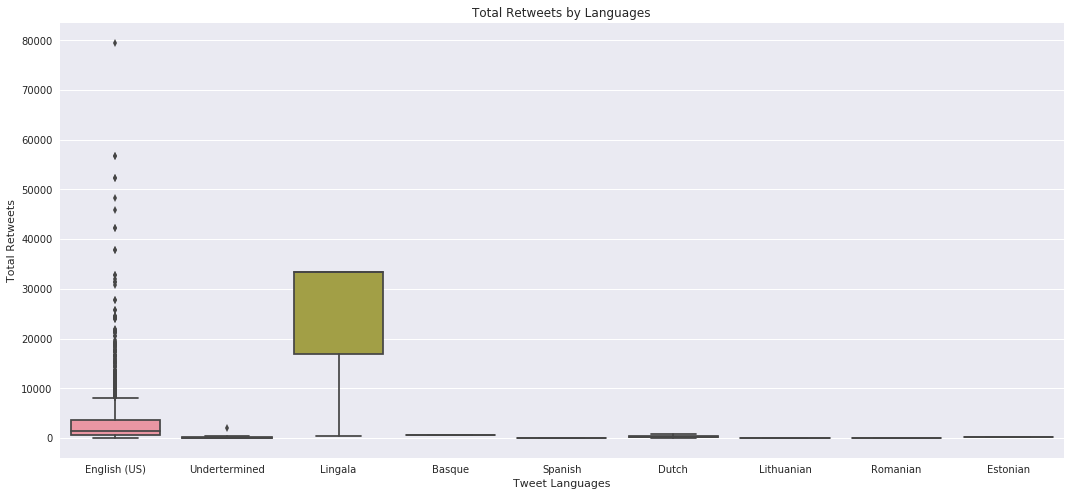

In [40]:
#Insight 1
#Create box and whisker plot of Total Retweets by Languages from Tweet data of We rate dogs
sn.set(rc={"figure.figsize":(18, 8)})
sn.boxplot(x = "twt.lang", y = 'retweet_count', data=twt_df)
plt.xlabel('Tweet Languages')
plt.ylabel('Total Retweets')
plt.title('Total Retweets by Languages')

Text(0.5,1,'Relationship Between Retweet and Favourites')

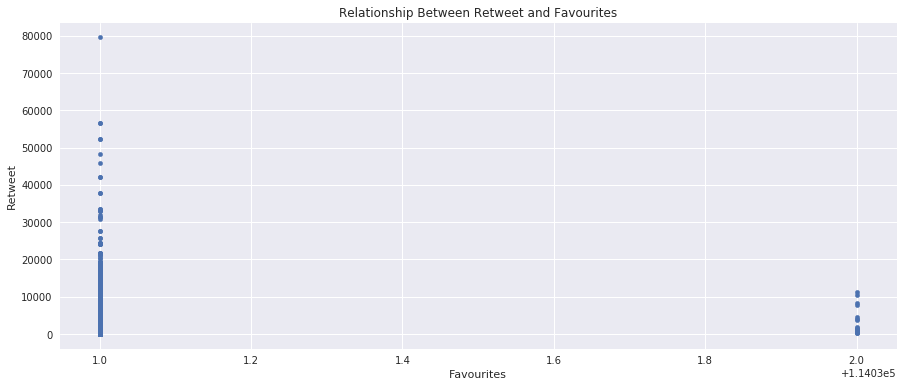

In [41]:
#Insight 2
#Examine the relationship between retweet and favourite
sn.set(rc={"figure.figsize":(18, 6)})
twt_df.plot.scatter(y='retweet_count', x='favourites_count', figsize=[15,6])
plt.ylabel('Retweet')
plt.xlabel('Favourites')
plt.title('Relationship Between Retweet and Favourites')

Text(0.5,1,'Relationship Between Retweet and Followers')

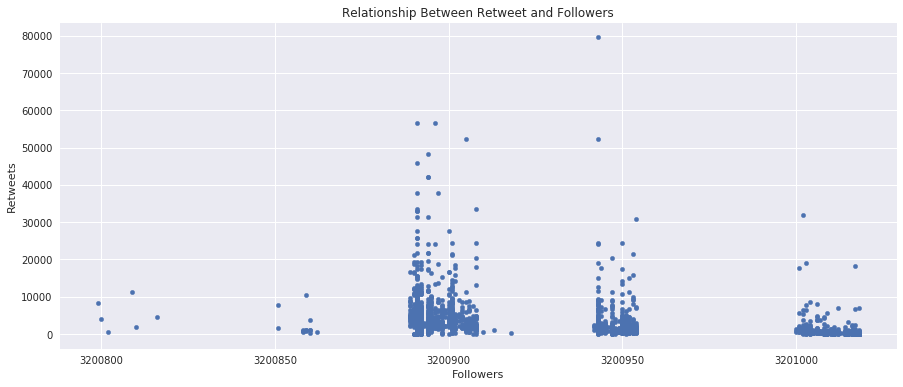

In [42]:
#Insight 3
#Examine the relationship between retweet and follower
sn.set(rc={"figure.figsize":(18, 6)})
twt_df.plot.scatter(y='retweet_count', x='followers_count', figsize=[15,6])
plt.xlabel('Followers')
plt.ylabel('Retweets')
plt.title('Relationship Between Retweet and Followers')

Text(0,0.5,' ')

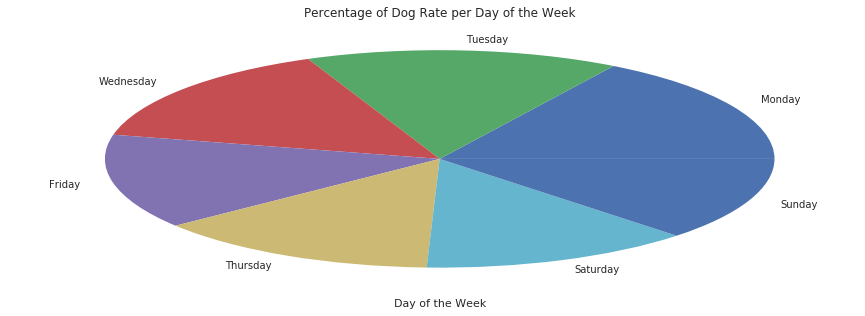

In [45]:
#Iinsight 4
#Create a pie chart that shows percentage of dog rate tweet per each calendar month
twt_df['twt.created_id'].dt.day_name().value_counts(normalize=True).mul(100).round(2).plot.pie(figsize=[15,5])
plt.title('Percentage of Dog Rate per Day of the Week')
plt.xlabel("Day of the Week")
plt.ylabel(" ")

#plt.ylabel("Percentage of Dog Rate Tweet")

Text(0,0.5,'Percentage of Dog Rate Tweet')

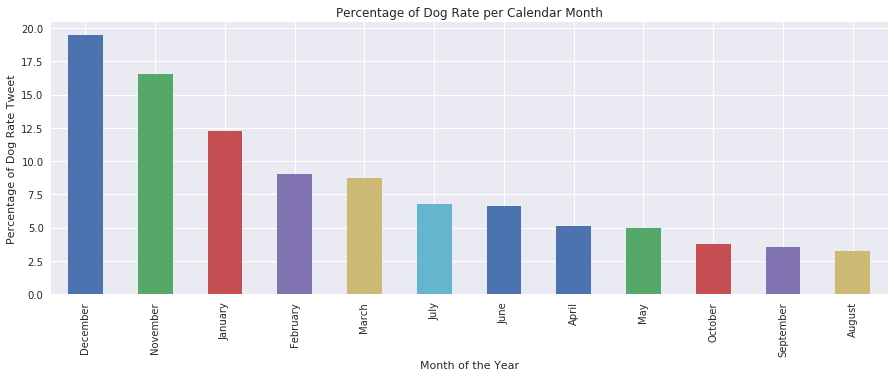

In [44]:
#Insight 5
#Create a bar chart that shows percentage of dog rate tweet per each calendar month
twt_df['twt.created_id'].dt.month_name().value_counts(normalize=True).mul(100).round(2).plot.bar(figsize=[15,5])
plt.title('Percentage of Dog Rate per Calendar Month')
plt.xlabel("Month of the Year")
plt.ylabel("Percentage of Dog Rate Tweet")

### Insights:
1. From insight 1, English (US) and Lingala appear to have generated a lot of retweets as seen in the insight 1 while the rest of the langugage captured barely garnered any meaningful or reasonable retweet. English (US) had a lot of retweet more than expected as captured by outliers of the retweet counts while Lingala only appear moderate and lot more in comparison with the other language. 

2.  The relationship between favourities and retweets neither depict positive nor negative negative correlation between the factor. In fact as seen from insight 2, there is zero relationship or no relationship can be inferred from the visual.

3.  From the insight 3, the visual evidence obtained from the scatter plot of retweet and follower counts show that higher follower counts might not result in higher retween as there seems to exist no relationship between the two factors.

4.  Monday, Tuesday and Wednesday accounted for 50% of the dog ratings performed while the remaining four days equally account for the remaining 50% as seen in insight 4.

5.  From the insight 5, it is evident that many of the dog ratings were in December, November and January. At the same, August, September and October are the months that dog ratings are least done.